<a href="https://colab.research.google.com/github/SyedSihabUsSakib/Thesis/blob/master/Copy_of_Copy_of_xlm_roberta_level_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
datapath = '/content/drive/My Drive/Colab Notebooks/dataset.csv'
df = pd.read_csv(datapath)
df.head()

,text,label,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,পাড়ায় ঢুকলে পা ভেঙ্গে দিব,Cy-Threat,NaN,NaN,NaN,NaN
1,গাধার মত বুদ্ধি হলে সমস্যায় পড়বেই\r,Cy-Flaming,NaN,NaN,NaN,NaN
2,সে হাতির মত শরীর নিয়ে ক্রিকেট খেলার স্বপ্ন দেখে\r,Cy-Pull-a-Pig,NaN,NaN,NaN,NaN
3,কালো মানুষ মানেই সন্ত্রাসী\r,Cy-Racism,NaN,NaN,NaN,NaN
4,পাড়ায় আসলে তোমাকে চা খাওয়াবো\r,Not Bullying,NaN,NaN,NaN,NaN


<Axes: xlabel='label'>

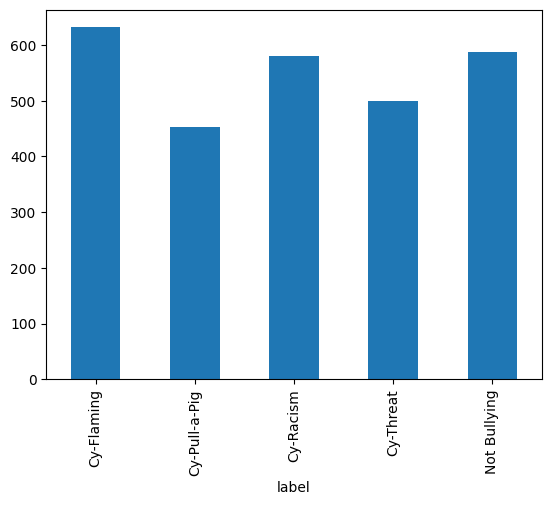

In [3]:
df.groupby(['label']).size().plot.bar()

In [4]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.5 MB/s eta 0:00:00


In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")
#from transformers import AutoTokenizer
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
example_text = 'আমি তাকে মেরে ফেলবো'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")

print(tokenizer)
#print(bert_input['input_ids'])
#print(bert_input['token_type_ids'])
#print(bert_input['attention_mask'])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


BertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [6]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] আমি তাকে ম [SEP]


In [7]:
import torch
import numpy as np
from transformers import BertTokenizer
#from transformers import AutoTokenizer
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

#model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

#tokenizer = BertTokenizer.from_pretrained("xlm-roberta-base")
labels = {'Cy-Flaming':0,
          'Cy-Racism':1,
          'Cy-Threat':2,
          'Cy-Pull-a-Pig':3,
          'Not Bullying':4,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [8]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=95), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

2200 275 276


In [9]:
from torch import nn
from transformers import BertModel
#from transformers import AutoTokenizer
#from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")



from transformers import XLMRobertaModel
import torch.nn as nn

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, 5)  # Replace 'num_classes' with the actual number of classes in your task

    def forward(self, input_id, mask):
        outputs = self.bert(input_ids=input_id, attention_mask=mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        return linear_output


In [10]:

from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data,learning_rate, epochs):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            model.eval()
            test_labels = []
            test_preds = []
            with torch.no_grad():
                for test_input, test_label in test_dataloader:
                    test_labels += test_label.tolist()
                    test_label = test_label.to(device)
                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)
                    preds = output.argmax(dim=1).tolist()
                    test_preds += preds
            precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
            print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')
        
                  
EPOCHS = 7
model = BertClassifier()
LR = 1e-5
              
train(model, df_train, df_val,df_test ,LR, EPOCHS)



"""
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data, learning_rate, epochs):

    # create dataloaders for training, validation, and test sets
    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)



    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # create optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    for epoch_num in range(epochs):

        # training loop
         for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

        # test loop
        model.eval()
        test_labels = []
        test_preds = []
        with torch.no_grad():
            for test_input, test_label in test_dataloader:
                test_labels += test_label.tolist()
                test_label = test_label.to(device)
                mask = test_input['attention_mask'].to(device)
                input_id = test_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                preds = output.argmax(dim=1).tolist()
                test_preds += preds
        precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
        print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')

        # update model parameters
        
"""


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1100/1100 [04:48<00:00,  3.81it/s]


Epochs: 1 | Train Loss:  0.502                 | Train Accuracy:  0.625                 | Val Loss:  0.409                 | Val Accuracy:  0.709
Test Precision: 0.7700 | Test Recall: 0.7609 | Test F1 Score: 0.7558


100%|██████████| 1100/1100 [04:49<00:00,  3.80it/s]


Epochs: 2 | Train Loss:  0.249                 | Train Accuracy:  0.830                 | Val Loss:  0.321                 | Val Accuracy:  0.789
Test Precision: 0.8209 | Test Recall: 0.8188 | Test F1 Score: 0.8132


100%|██████████| 1100/1100 [04:49<00:00,  3.80it/s]


Epochs: 3 | Train Loss:  0.122                 | Train Accuracy:  0.930                 | Val Loss:  0.400                 | Val Accuracy:  0.767
Test Precision: 0.7808 | Test Recall: 0.7717 | Test F1 Score: 0.7720


100%|██████████| 1100/1100 [04:49<00:00,  3.80it/s]


Epochs: 4 | Train Loss:  0.070                 | Train Accuracy:  0.958                 | Val Loss:  0.423                 | Val Accuracy:  0.731
Test Precision: 0.8042 | Test Recall: 0.8007 | Test F1 Score: 0.8006


100%|██████████| 1100/1100 [04:49<00:00,  3.80it/s]


Epochs: 5 | Train Loss:  0.059                 | Train Accuracy:  0.962                 | Val Loss:  0.379                 | Val Accuracy:  0.807
Test Precision: 0.7739 | Test Recall: 0.7717 | Test F1 Score: 0.7701


100%|██████████| 1100/1100 [04:49<00:00,  3.80it/s]


Epochs: 6 | Train Loss:  0.034                 | Train Accuracy:  0.975                 | Val Loss:  0.443                 | Val Accuracy:  0.793
Test Precision: 0.8462 | Test Recall: 0.8442 | Test F1 Score: 0.8440


100%|██████████| 1100/1100 [04:49<00:00,  3.80it/s]


Epochs: 7 | Train Loss:  0.017                 | Train Accuracy:  0.991                 | Val Loss:  0.469                 | Val Accuracy:  0.782
Test Precision: 0.8280 | Test Recall: 0.8261 | Test F1 Score: 0.8255


'\nfrom torch.optim import Adam\nfrom tqdm import tqdm\nfrom sklearn.metrics import precision_recall_fscore_support\n\ndef train(model, train_data, val_data, test_data, learning_rate, epochs):\n\n    # create dataloaders for training, validation, and test sets\n    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)\n    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)\n    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)\n    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)\n\n\n\n    use_cuda = torch.cuda.is_available()\n    device = torch.device("cuda" if use_cuda else "cpu")\n\n    # create optimizer and loss function\n    criterion = nn.CrossEntropyLoss()\n    optimizer = Adam(model.parameters(), lr=learning_rate)\n\n    for epoch_num in range(epochs):\n\n        # training loop\n         for epoch_num in range(epochs):\n\n            total_acc_train = 0\n            total_loss_train = 0\n\n  

In [11]:
labels = {'Cy-Flaming':0,
          'Cy-Racism':1,
          'Cy-Threat':2,
          'Cy-Pull-a-Pig':3,
          'Not Bullying':4,
          }
inv_labels = {v: k for k, v in labels.items()}

# evaluate on test set and get individual metrics for each class
test = Dataset(df_test)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
test_labels = []
test_preds = []
with torch.no_grad():
    for test_input, test_label in test_dataloader:
        test_labels += test_label.tolist()
        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        preds = output.argmax(dim=1).tolist()
        test_preds += preds

precision, recall, f1_score, support = precision_recall_fscore_support(test_labels, test_preds, labels=list(labels.values()), average=None)

# print individual metrics for each class
for i, label in inv_labels.items():
    print(f"Metrics for {label}:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1_score[i]:.4f}")
    print(f"Support: {support[i]}")
#This code first defines the mapping between the class labels and their corresponding indices, and then uses precision_recall_fscore_support with labels=list(labels.values()) and average=None to get the individual metrics for each class. Finally, it prints the metrics for each class using the inv_labels dictionary to map the indices back to their original labels.








Metrics for Cy-Flaming:
Precision: 0.7460
Recall: 0.7121
F1-score: 0.7287
Support: 66
Metrics for Cy-Racism:
Precision: 0.8909
Recall: 0.8596
F1-score: 0.8750
Support: 57
Metrics for Cy-Threat:
Precision: 0.8824
Recall: 0.9184
F1-score: 0.9000
Support: 49
Metrics for Cy-Pull-a-Pig:
Precision: 0.7551
Recall: 0.9024
F1-score: 0.8222
Support: 41
Metrics for Not Bullying:
Precision: 0.8621
Recall: 0.7937
F1-score: 0.8264
Support: 63


In [12]:

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.826


#Confusion Matrix


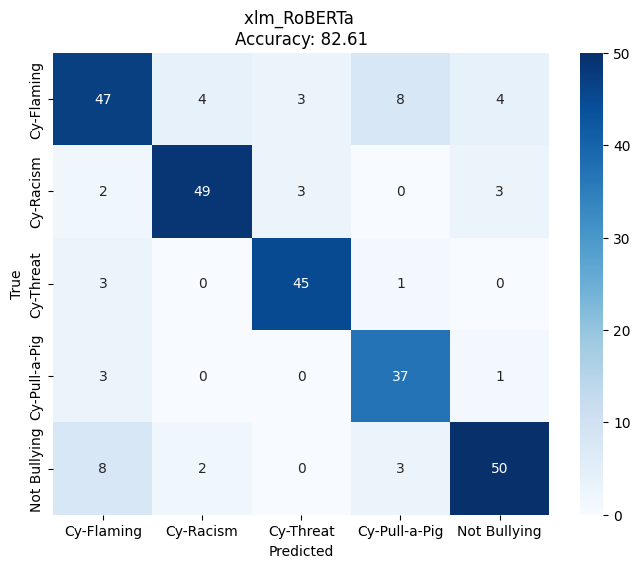

In [13]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds, labels=list(labels.values()))

# Plot confusion matrix
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=inv_labels.values(), yticklabels=inv_labels.values())
# plt.title("Confusion Matrix")
plt.title('xlm_RoBERTa \nAccuracy: {0:.2f}'.format(accuracy_score(test_labels, test_preds)*100))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#ROC

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def generate_roc_curve(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model.eval()
    test_labels = []
    test_probs = []

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_labels += test_label.tolist()
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            probs = torch.softmax(output, dim=1).tolist()
            test_probs += probs

    test_labels = np.array(test_labels)
    test_probs = np.array(test_probs)

    # Binarize the labels
    test_labels_bin = label_binarize(test_labels, classes=np.arange(5))  # Adjust the number of classes as needed

    # Calculate FPR, TPR, and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(test_labels_bin.shape[1]):  # Assuming multiple classes
        fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'orange', 'green', 'red', 'purple']  # Adjust the colors based on the number of classes
    for i, color in zip(range(test_labels_bin.shape[1]), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


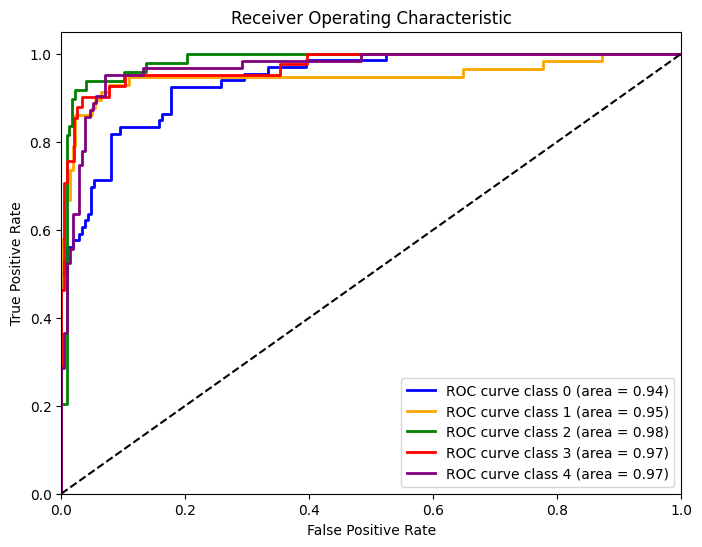

In [15]:
generate_roc_curve(model, df_test)
